<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fidelity-vs-interaction-parameters" data-toc-modified-id="Fidelity-vs-interaction-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fidelity vs interaction parameters</a></span><ul class="toc-item"><li><span><a href="#Fredkin-gate" data-toc-modified-id="Fredkin-gate-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fredkin gate</a></span></li></ul></li></ul></div>

# Fidelity vs interaction parameters
In this notebook we study how, given a fully trained net, the fidelity (measured with single states) changes when varying a single Hamiltonian parameter.

In the following plots we
1. Take a sample of random states (with corresponding target states), and some trained qubit network,
2. Compute the fidelity on each of these states, as a function of one of the interaction parameters,
3. Plot the result.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
from IPython.display import display
from IPython.core.debugger import set_trace
from collections import OrderedDict
import itertools
import os
import sys
import pickle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sympy
import pandas as pd

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import cufflinks

import qutip
import theano
import theano.tensor as T

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network.net_analysis_tools as nat
import qubit_network.utils
from qubit_network.utils import chop, complex2bigreal, bigreal2complex, bigreal2qobj
from qubit_network.QubitNetwork import pauli_product
from qubit_network.model import QubitNetworkGateModel
from qubit_network.Optimizer import Optimizer
from qubit_network.net_analysis_tools import NetDataFile, NetsDataFolder

## Fredkin gate
Load a 3 qubits + 1 ancilla network, trained to implement the Fredkin gate, check its fidelity, and have a look at the trained parameters.
It is here interesting to notice how the parameters vary when well outside of the range corresponding to fidelity 1.
For each state we have a very stable sinusoidal variation of the fidelity.

In [58]:
trained_net = NetsDataFolder('../data/nets').filter('toffoli_Banchi*')
trained_net.plot_parameters(hlines=np.arange(-2 * np.pi, 2 * np.pi, np.pi / 2))

In [68]:
foo = NetsDataFolder('../data/nets').filter('fredkin*')
foo.view_fidelities()

,target gates,names,fidelity
0,fredkin,fredkin_3q+1a_allpairs_onlyz_0.999999fid,1.000000
1,fredkin,fredkin_3q+1a_paperTopology_1fid,0.382178
2,fredkin,fredkin_3q_all_1fid,1.000000
3,fredkin,fredkin_3q+1a_allpairs_onlyz_0.996fid,0.998031
4,fredkin,fredkin_3q+1a_allpairs_onlyz_0.998fid,0.998918
5,fredkin,fredkin_3q_all_0.9999fid,0.999994
6,fredkin,fredkin_3q_all_1fid_2,1.000000
7,fredkin,fredkin_3q+1a_allpairs_onlyz_0.99999fid,0.999994
8,fredkin,fredkin_Banchietal,1.000000
9,fredkin,fredkin_3q_all_0.99999fid,0.999996


In [71]:
foo = NetsDataFolder('../data/nets').filter('toffoli*')
foo.view_fidelities()

,target gates,names,fidelity
0,toffoli,toffoli_3qb_onlyDiag(1),0.999335
1,toffoli,toffoli_3qb_onlyDiag(4),1.000000
2,toffoli,toffoli_3q_all_0.9999fid,0.999953
3,toffoli,toffoli,1.000000
4,toffoli,toffoli_3q+1a_all_0.989fid,0.994668
5,toffoli,toffoli_3qb_onlyDiag_fromAbdullah,1.000000
6,toffoli,toffoli_3qb_onlyDiag_0.99999999fid,1.000000
7,toffoli,toffoli_3q_all_1fid,1.000000
8,toffoli,toffoli_Banchietal,0.785700
9,toffoli,toffoli_3qb_onlyDiag(3),1.000000


In [79]:
nets = NetsDataFolder('../data/nets').filter('fredk*')
pd.DataFrame({
    'name': [net.name for net in nets],
    'num_qubits': [net.num_qubits for net in nets],
    'fidelity': [net.fidelity_test() for net in nets]
}).sort_values(by=['num_qubits', 'fidelity'])

,fidelity,name,num_qubits
5,0.999994,fredkin_3q_all_0.9999fid,3
9,0.999996,fredkin_3q_all_0.99999fid,3
6,1.000000,fredkin_3q_all_1fid_2,3
2,1.000000,fredkin_3q_all_1fid,3
1,0.349279,fredkin_3q+1a_paperTopology_1fid,4
3,0.997692,fredkin_3q+1a_allpairs_onlyz_0.996fid,4
4,0.998938,fredkin_3q+1a_allpairs_onlyz_0.998fid,4
7,0.999995,fredkin_3q+1a_allpairs_onlyz_0.99999fid,4
0,1.000000,fredkin_3q+1a_allpairs_onlyz_0.999999fid,4
8,1.000000,fredkin_Banchietal,4


Study fidelity vs absolute variation of a single Hamiltonian parameter.
As expected, for some value of the parameter, we get fidelity one for all test states.

The regularity of the oscillatory behaviour when outside of the *equilibrium* values is striking:

<IPython.core.display.Javascript object>


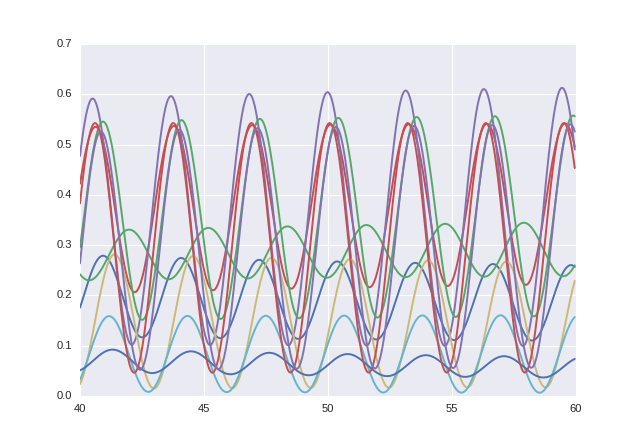

In [10]:
states, target_states = net.generate_training_data(net.target_gate, 10)
xs = np.arange(40, 60, 0.05)

fidelities = plots_generator(states, target_states, xs, 4)
fig, ax = plt.subplots(1, 1)
for fids in fidelities:
    ax.plot(xs, fids)
    fig.canvas.draw()

Same as above, but this time we try to vary the 7th parameter, having an equilibrium value around $-3$.
We again observe the same phenomenon: outside of the value corresponding to maximum fidelity, the fidelity for every single state has a very regular oscillatory behaviour.

<IPython.core.display.Javascript object>


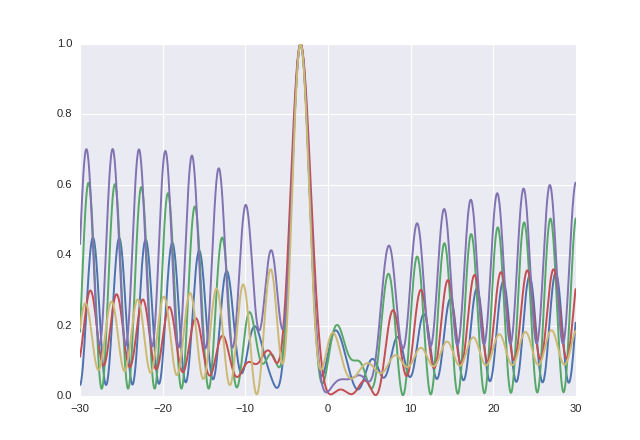

In [14]:
states, target_states = net.generate_training_data(net.target_gate, 5)
xs = np.arange(-30, 30, .05)

fidelities = plots_generator(states, target_states, xs, 6)
fig, ax = plt.subplots(1, 1)
for fids in fidelities:
    ax.plot(xs, fids)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


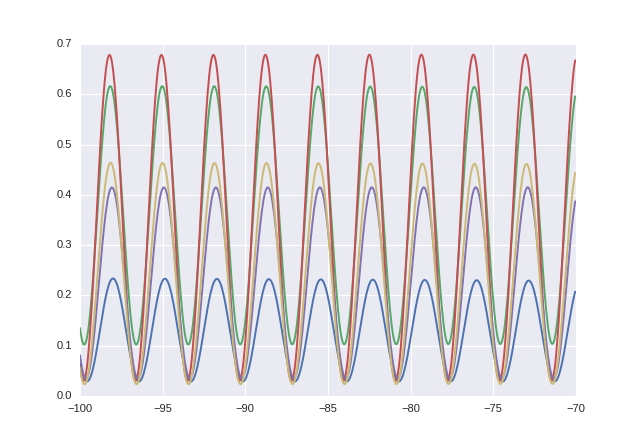

In [15]:
states, target_states = net.generate_training_data(net.target_gate, 5)
xs = np.arange(-100, -70, .05)

fidelities = plots_generator(states, target_states, xs, 6)
fig, ax = plt.subplots(1, 1)
for fids in fidelities:
    ax.plot(xs, fids)
    fig.canvas.draw()

In [48]:
net = qn.load_network_from_file('../data/nets/qft_3q+1a_all_0.79f')
plots_generator = qn.fidelity_vs_J(net)
display(net.J.get_value())
# net.test_fidelity(n_samples=1000)

array([-0.29850267, -1.46704348,  0.27684499,  2.04663445, -0.43436746,
        1.49283174,  1.15268932,  0.89091222, -0.28120247, -0.82396404,
        0.21988497,  0.61178863,  0.86516206,  0.92033021, -2.1176642 ,
       -0.4562144 , -0.07789475,  0.05298861,  1.12930951, -0.32242026,
        0.61208154, -0.17438271,  0.07047908,  1.66386472,  0.5628075 ,
       -0.87830054, -0.22908957,  0.82263958,  0.20686379, -0.04685071,
       -1.18905421,  0.97359189, -0.55989583,  0.41969494, -0.43456166,
        1.23424422,  0.65963339,  0.03347334, -0.35963848, -0.42953171,
        0.83978453, -2.59549186,  0.04057105, -0.48507785, -0.89419905,
       -0.00852444,  0.88467658,  1.04071491,  0.60444049,  0.51534824,
       -1.67110963, -1.58159529, -0.63853596, -0.91239705,  1.02477751,
       -0.85488676,  0.2468933 ,  0.59162231, -0.0181673 ,  1.0108454 ,
        0.88161222, -0.30335828,  0.25558398,  0.07407621,  0.08899823,
        1.59912803])

<IPython.core.display.Javascript object>


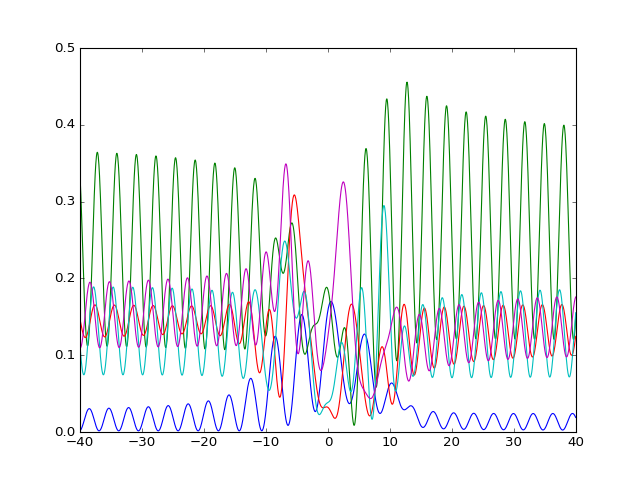

In [51]:
pstates, target_states = net.generate_training_data(net.target_gate, 10)
xs = np.arange(-40, 40, 0.05)

fidelities = plots_generator(states, target_states, xs, 0)
fig, ax = plt.subplots(1, 1)
for fids in fidelities:
    ax.plot(xs, fids)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


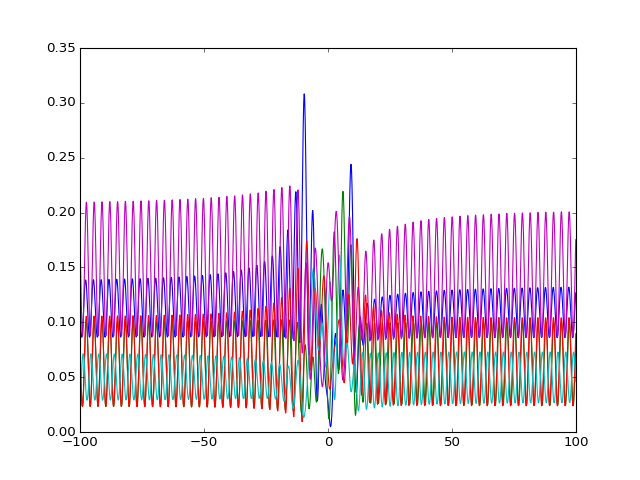

In [56]:
pstates, target_states = net.generate_training_data(net.target_gate, 5)
xs = np.arange(-100, 100, 0.1)

fidelities = plots_generator(states, target_states, xs, 0)
fig, ax = plt.subplots(1, 1)
for fids in fidelities:
    ax.plot(xs, fids)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


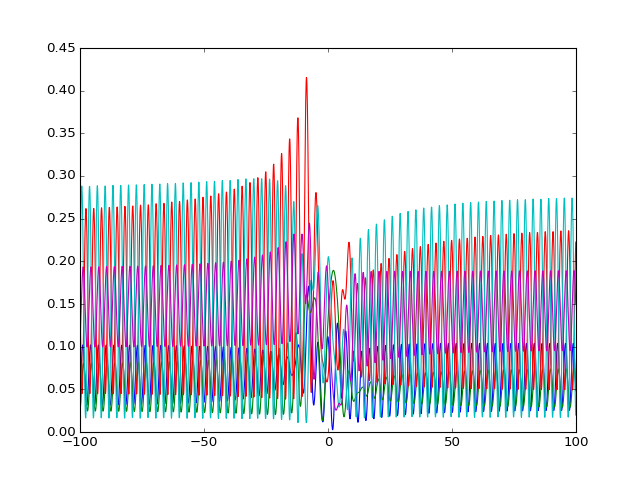

In [57]:
fidelities = plots_generator(states, target_states, xs, 1)
fig, ax = plt.subplots(1, 1)
for fids in fidelities:
    ax.plot(xs, fids)
    fig.canvas.draw()

<IPython.core.display.Javascript object>


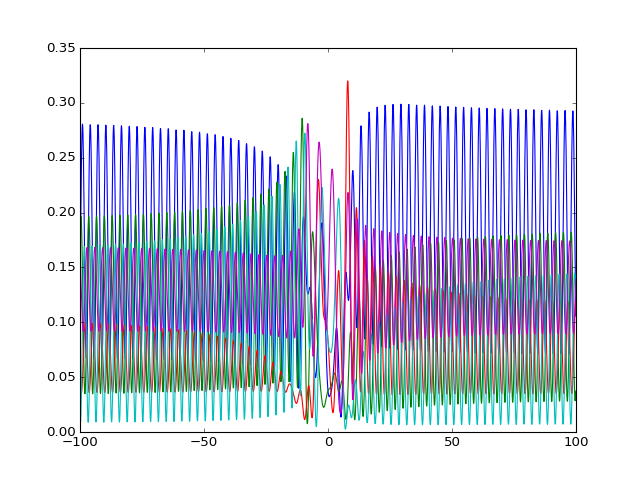

In [58]:
fidelities = plots_generator(states, target_states, xs, 2)
fig, ax = plt.subplots(1, 1)
for fids in fidelities:
    ax.plot(xs, fids)
    fig.canvas.draw()